In [3]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader.data as web

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV
import yfinance as yf

from datetime import datetime, timedelta
import requests
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline


test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14




In [4]:
import datetime




end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*10)).strftime('%Y-%m-%d')

tesla_data = yf.download('TSLA', start=start_date, end=end_date)
apple_data = yf.download('AAPL', start=start_date, end=end_date)
amazon_data = yf.download('AMZN', start=start_date, end=end_date)


#GOLD Data

gold_data = yf.download('GC=F', start=start_date, end=end_date)


#ETF's

api_key = '2YW9PTCOWXKLLTNS'


qqq_symbol = 'QQQ'
spdr_symbol = 'SPY'
ishr_symbol = 'IWM'

output_format = 'json'

base_url = 'https://www.alphavantage.co/query'

def fetch_etf_data(api_key, symbol, output_format, start_date, end_date):
    # Define the API parameters
    params = {
        'function': 'TIME_SERIES_DAILY',  # Daily time series data
        'symbol': symbol,
        'outputsize': 'full',  # Retrieve full historical data
        'datatype': output_format,
        'apikey': api_key,
        'start_date': start_date,  # Specify the start date
        'end_date': end_date      # Specify the end date
    }

    try:

        response = requests.get(base_url, params=params)
        data = response.json() if output_format == 'json' else response.text

        # Check for API request success
        if 'Time Series (Daily)' in data:
            return data['Time Series (Daily)']
        else:
            print("API request was not successful. Check your API key or symbol.")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


invesco_data = pd.DataFrame(fetch_etf_data(api_key, qqq_symbol, output_format, start_date, end_date))
ishares_data = pd.DataFrame(fetch_etf_data(api_key, ishr_symbol, output_format, start_date, end_date))
spdr_data = pd.DataFrame(fetch_etf_data(api_key, spdr_symbol, output_format, start_date, end_date))

spdr_data = spdr_data.T
ishares_data = ishares_data.T
invesco_data = invesco_data.T


#bitcoin

api_key = "5DyC56vN-RWdz61xD4-m"
url = f"https://www.quandl.com/api/v3/datasets/BCHAIN/MKPRU/data.json?start_date={start_date}&end_date={end_date}&api_key={api_key}"
response = requests.get(url)
bitcon_data = response.json()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Common functions

In [5]:
df = tesla_data
df['date']=df.index

df=df.reset_index(drop=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,date
0,11.516667,11.952667,11.413333,11.913333,11.913333,124666500,2013-10-11
1,11.666667,12.166667,11.610000,11.981333,11.981333,116544000,2013-10-14
2,12.352000,12.586000,12.212000,12.262667,12.262667,164677500,2013-10-15
3,12.326667,12.486667,12.139333,12.237333,12.237333,123081000,2013-10-16
4,12.236000,12.320000,12.066000,12.186667,12.186667,100575000,2013-10-17


# Load data

In [6]:

# Convert Date column to datetime
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,open,high,low,close,adj_close,volume,date,month
0,11.516667,11.952667,11.413333,11.913333,11.913333,124666500,2013-10-11,10
1,11.666667,12.166667,11.610000,11.981333,11.981333,116544000,2013-10-14,10
2,12.352000,12.586000,12.212000,12.262667,12.262667,164677500,2013-10-15,10
3,12.326667,12.486667,12.139333,12.237333,12.237333,123081000,2013-10-16,10
4,12.236000,12.320000,12.066000,12.186667,12.186667,100575000,2013-10-17,10
5,12.276667,12.397333,12.168000,12.226667,12.226667,88962000,2013-10-18,10
6,12.218667,12.226000,11.400000,11.506667,11.506667,172981500,2013-10-21,10
7,11.366667,11.852000,11.074000,11.436000,11.436000,170800500,2013-10-22,10
8,11.260667,11.454000,10.676667,10.966667,10.966667,199806000,2013-10-23,10
9,11.000000,11.633333,10.855333,11.543333,11.543333,162385500,2013-10-24,10


# Split into train, dev and test set

In [7]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1510
num_cv = 502
num_test = 502
train.shape = (1510, 8)
cv.shape = (502, 8)
train_cv.shape = (2012, 8)
test.shape = (502, 8)


# EDA

Text(0, 0.5, 'USD')

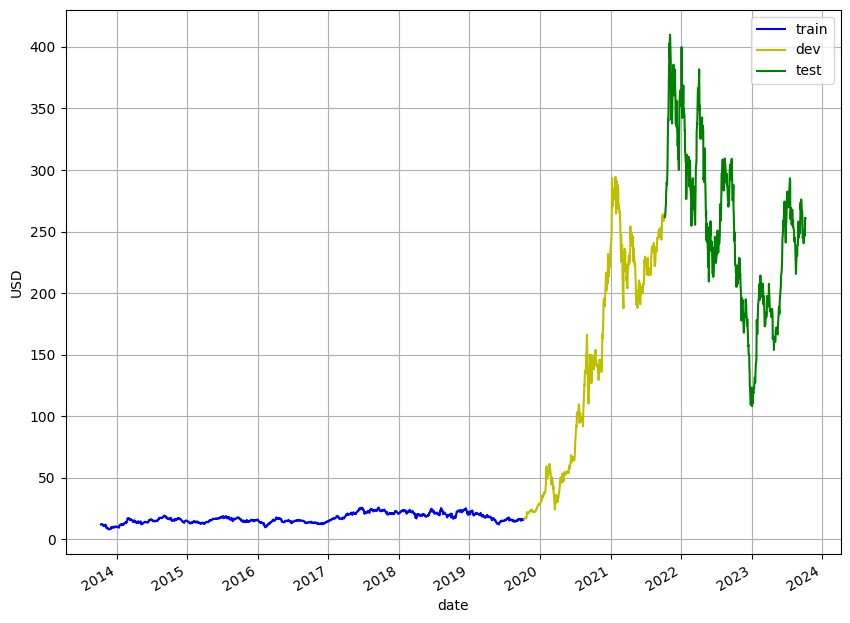

In [8]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# MODEL2-XGBOOST REGRESSION

In [9]:
!pip install xgboost

In [10]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline



test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# common functions

In [11]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean()
    std_list = df[col].rolling(window = N, min_periods=1).std()

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """

    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row-feat_mean) / feat_std

    return row_scaled

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)

    return rmse, mape, est

# load data

In [12]:


df = apple_data
df['date']=df.index

df=df.reset_index(drop=True)


# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,open,high,low,close,adj_close,volume,date,month
0,17.392500,17.637142,17.327143,17.600357,15.360734,267738800,2013-10-11,10
1,17.493929,17.770714,17.476786,17.715714,15.461405,261898000,2013-10-14,10
2,17.768213,17.928572,17.697144,17.809999,15.543694,320073600,2013-10-15,10
3,17.885357,17.947500,17.829643,17.896786,15.619434,251101200,2013-10-16,10
4,17.856428,18.027857,17.845715,18.017857,15.725103,253593200,2013-10-17,10


Text(0, 0.5, 'USD')

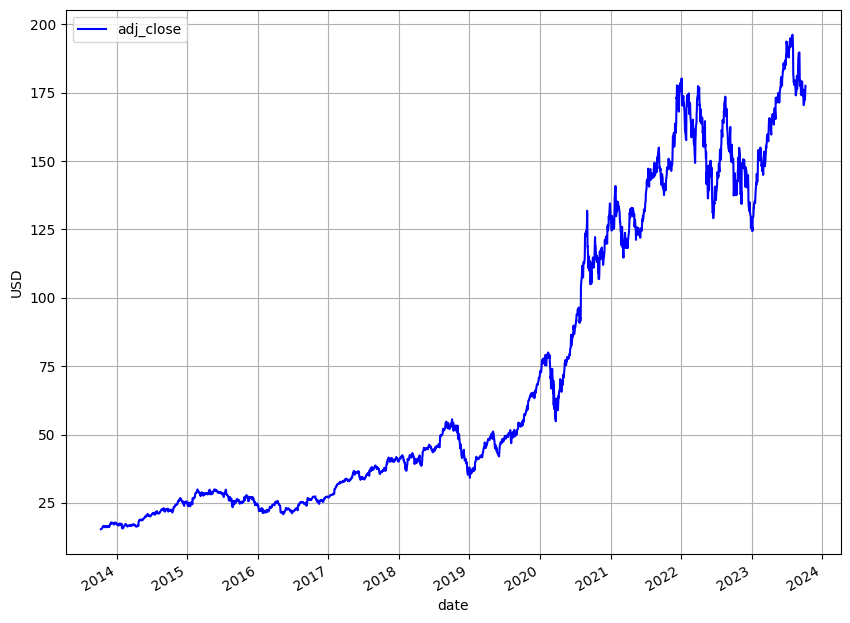

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering
We will generate the following features:

Mean 'adj_close' of each month,
Difference between high and low of each day,
Difference between open and close of each day,
Mean volume of each month

In [14]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,adj_close,volume,date,month,range_hl,range_oc
0,15.360734,267738800,2013-10-11,10,0.309999,-0.207857
1,15.461405,261898000,2013-10-14,10,0.293928,-0.221785
2,15.543694,320073600,2013-10-15,10,0.231428,-0.041786
3,15.619434,251101200,2013-10-16,10,0.117857,-0.011429
4,15.725103,253593200,2013-10-17,10,0.182142,-0.161428


In [15]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
print(df.head())

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

   adj_close     volume       date  month  range_hl  range_oc  order_day
0  15.360734  267738800 2013-10-11     10  0.309999 -0.207857          0
1  15.461405  261898000 2013-10-14     10  0.293928 -0.221785          1
2  15.543694  320073600 2013-10-15     10  0.231428 -0.041786          2
3  15.619434  251101200 2013-10-16     10  0.117857 -0.011429          3
4  15.725103  253593200 2013-10-17     10  0.182142 -0.161428          4


['adj_close', 'range_hl', 'range_oc', 'volume']

In [16]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)





print(train_shift.head())

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

df.head()

<ipython-input-16-59328cf0230f>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

   order_day  adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3
0          3        15.360734        0.309999       -0.207857     267738800
1          4        15.461405        0.293928       -0.221785     261898000
2          5        15.543694        0.231428       -0.041786     320073600
3          6        15.619434        0.117857       -0.011429     251101200
4          7        15.725103        0.182142       -0.161428     253593200


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,15.619434,251101200,2013-10-16,10,0.117857,-0.011429,3,15.543694,0.231428,-0.041786,320073600.0,15.461405,0.293928,-0.221785,261898000.0,15.360734,0.309999,-0.207857,267738800.0
4,15.725103,253593200,2013-10-17,10,0.182142,-0.161428,4,15.619434,0.117857,-0.011429,251101200.0,15.543694,0.231428,-0.041786,320073600.0,15.461405,0.293928,-0.221785,261898000.0
5,15.861935,290542000,2013-10-18,10,0.126785,-0.103571,5,15.725103,0.182142,-0.161428,253593200.0,15.619434,0.117857,-0.011429,251101200.0,15.543694,0.231428,-0.041786,320073600.0
6,16.250620,398106800,2013-10-21,10,0.456429,-0.342501,6,15.861935,0.126785,-0.103571,290542000.0,15.725103,0.182142,-0.161428,253593200.0,15.619434,0.117857,-0.011429,251101200.0
7,16.204176,534063600,2013-10-22,10,0.729286,0.233572,7,16.250620,0.456429,-0.342501,398106800.0,15.861935,0.126785,-0.103571,290542000.0,15.725103,0.182142,-0.161428,253593200.0


In [17]:
# # Get mean of adj_close of each month
df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb,
               left_on=['month'],
            right_on=['month'],
               how='left').fillna(0)
df.head()


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean
0,15.619434,251101200,2013-10-16,10,0.117857,-0.011429,3,15.543694,0.231428,-0.041786,320073600.0,15.461405,0.293928,-0.221785,261898000.0,15.360734,0.309999,-0.207857,267738800.0,68.0616
1,15.725103,253593200,2013-10-17,10,0.182142,-0.161428,4,15.619434,0.117857,-0.011429,251101200.0,15.543694,0.231428,-0.041786,320073600.0,15.461405,0.293928,-0.221785,261898000.0,68.0616
2,15.861935,290542000,2013-10-18,10,0.126785,-0.103571,5,15.725103,0.182142,-0.161428,253593200.0,15.619434,0.117857,-0.011429,251101200.0,15.543694,0.231428,-0.041786,320073600.0,68.0616
3,16.250620,398106800,2013-10-21,10,0.456429,-0.342501,6,15.861935,0.126785,-0.103571,290542000.0,15.725103,0.182142,-0.161428,253593200.0,15.619434,0.117857,-0.011429,251101200.0,68.0616
4,16.204176,534063600,2013-10-22,10,0.729286,0.233572,7,16.250620,0.456429,-0.342501,398106800.0,15.861935,0.126785,-0.103571,290542000.0,15.725103,0.182142,-0.161428,253593200.0,68.0616


In [18]:
# # Get mean of volume of eaxh month
df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
df_gb = df_gb.rename(columns={'volume':'volume_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb,
              left_on=['month'],
               right_on=['month'],
               how='left').fillna(0)

df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean
0,15.619434,251101200,2013-10-16,10,0.117857,-0.011429,3,15.543694,0.231428,-0.041786,...,15.461405,0.293928,-0.221785,261898000.0,15.360734,0.309999,-0.207857,267738800.0,68.0616,1.461228e+08
1,15.725103,253593200,2013-10-17,10,0.182142,-0.161428,4,15.619434,0.117857,-0.011429,...,15.543694,0.231428,-0.041786,320073600.0,15.461405,0.293928,-0.221785,261898000.0,68.0616,1.461228e+08
2,15.861935,290542000,2013-10-18,10,0.126785,-0.103571,5,15.725103,0.182142,-0.161428,...,15.619434,0.117857,-0.011429,251101200.0,15.543694,0.231428,-0.041786,320073600.0,68.0616,1.461228e+08
3,16.250620,398106800,2013-10-21,10,0.456429,-0.342501,6,15.861935,0.126785,-0.103571,...,15.725103,0.182142,-0.161428,253593200.0,15.619434,0.117857,-0.011429,251101200.0,68.0616,1.461228e+08
4,16.204176,534063600,2013-10-22,10,0.729286,0.233572,7,16.250620,0.456429,-0.342501,...,15.861935,0.126785,-0.103571,290542000.0,15.725103,0.182142,-0.161428,253593200.0,68.0616,1.461228e+08


# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [19]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()
df.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

# Split into train, dev and test set

In [20]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1507
num_cv = 502
num_test = 502
train.shape = (1507, 27)
cv.shape = (502, 27)
train_cv.shape = (2009, 27)
test.shape = (502, 27)


# Scale the train, dev and test set

In [21]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 3.20738532e+01  3.20470434e+01  5.99142342e-01 -1.03616341e-02
  1.69683358e+08  3.20206726e+01  5.98980716e-01 -1.05088037e-02
  1.69807530e+08  3.19946594e+01  5.98567644e-01 -1.08823011e-02
  1.69910993e+08]
scaler.var_ = [1.15280645e+02 1.15083085e+02 1.65878395e-01 1.78974043e-01
 9.25269707e+15 1.14909149e+02 1.65937662e-01 1.79003612e-01
 9.25234659e+15 1.14755463e+02 1.65919095e-01 1.78940664e-01
 9.25646859e+15]
train_scaled.shape = (1507, 13)
train_scaled.shape = (1507, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.532514,-1.538390,-0.902850,-0.074280,1.563455,-1.544770,-0.748863,-0.499366,0.957390,-1.552773,-0.708435,-0.465646,1.016810,2013-10-16,10
1,-1.522672,-1.531329,-1.181701,-0.002523,0.846419,-1.537093,-0.902292,-0.073926,1.562194,-1.543376,-0.747891,-0.498571,0.956101,2013-10-17,10
2,-1.509928,-1.521479,-1.023862,-0.357087,0.872326,-1.530028,-1.181094,-0.002175,0.845144,-1.535694,-0.901328,-0.073056,1.560771,2013-10-18,10
3,-1.473727,-1.508724,-1.159780,-0.220325,1.256445,-1.520170,-1.023282,-0.356710,0.871051,-1.528624,-1.180146,-0.001292,0.843881,2013-10-21,10
4,-1.478053,-1.472492,-0.350406,-0.785100,2.374688,-1.507406,-1.159176,-0.219959,1.255178,-1.518760,-1.022325,-0.355889,0.869782,2013-10-22,10


In [22]:
# Do scaling for dev set
cv_scaled = cv[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

# Now the entire dev set is scaled
cv_scaled.head()

<ipython-input-22-fe2e231cbbcc>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1507,2019-10-11,57.434196,1.024216,-0.050332,-0.973884,0.167005,-1.072988,0.905983,-1.061369,0.136829,0.924540,0.604580,-1.154266,0.549685
1508,2019-10-14,57.351524,1.091088,-0.218215,-0.872873,1.099982,-0.245805,-0.854177,-0.876309,-0.213046,1.089355,1.051301,-0.112038,-0.939263
1509,2019-10-15,57.217800,0.527217,0.626072,-1.153289,-0.436779,1.144088,-0.707309,1.012839,-0.986646,-0.026193,-0.787927,1.124975,-0.337049
1510,2019-10-16,56.986801,-1.068771,0.155841,0.912930,-0.817893,-0.296949,1.114842,0.980209,0.038472,-1.018681,-0.678473,-0.469934,1.148406
1511,2019-10-17,57.208073,-1.076218,0.175734,0.900484,-1.009248,0.018759,0.990488,-0.589945,1.154608,-0.564663,-1.058278,0.129095,0.929183


In [23]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 5.04437637e+01  5.03809924e+01  1.08539957e+00 -2.37666881e-02
  1.58696321e+08  5.03188149e+01  1.08366435e+00 -2.26177512e-02
  1.58785259e+08  5.02570253e+01  1.08238510e+00 -2.19148453e-02
  1.58878279e+08]
scaler_train_cv.var_ = [1.30982851e+03 1.30629009e+03 1.42523351e+00 8.79516556e-01
 8.28080600e+15 1.30286177e+03 1.42192814e+00 8.76408223e-01
 8.28326403e+15 1.29950776e+03 1.42061825e+00 8.75154717e-01
 8.28614174e+15]
train_cv_scaled.shape = (2009, 13)
train_cv_scaled.shape = (2009, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.962223,-0.963884,-0.715320,-0.019214,1.773397,-0.965708,-0.662282,-0.212747,1.132952,-0.968032,-0.648031,-0.198763,1.195898,2013-10-16,10
1,-0.959303,-0.961788,-0.810452,0.013156,1.015450,-0.963428,-0.714696,-0.020475,1.772157,-0.965240,-0.661514,-0.213651,1.131734,2013-10-17,10
2,-0.955522,-0.958864,-0.756604,-0.146788,1.042835,-0.961330,-0.809938,0.011952,1.014322,-0.962957,-0.713952,-0.021241,1.770827,2013-10-18,10
3,-0.944782,-0.955079,-0.802973,-0.085095,1.448871,-0.958403,-0.756027,-0.148276,1.041703,-0.960856,-0.809238,0.011209,1.013124,2013-10-21,10
4,-0.946066,-0.944324,-0.526851,-0.339865,2.630915,-0.954612,-0.802450,-0.086473,1.447678,-0.957925,-0.755303,-0.149133,1.040500,2013-10-22,10


In [24]:
# Do scaling for test set
test_scaled = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

# Now the entire test set is scaled
test_scaled.head()

<ipython-input-24-ee84e6701221>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2009,2021-10-08,141.265671,1.055253,-0.121632,-0.933621,-1.062358,0.923029,0.139329,1.061884,-0.923754,-0.138130,-1.148897,0.674582,0.474315
2010,2021-10-11,141.176697,0.256946,0.846455,-1.103401,-0.529960,-0.623478,1.153438,0.904500,0.169369,-1.073869,-0.684690,-0.462888,1.147578
2011,2021-10-12,139.891586,-0.744672,-0.391926,1.136599,1.151705,-0.503874,-0.647831,-0.742980,1.136987,-0.394007,0.985620,-1.013785,0.028166
2012,2021-10-13,139.298447,-1.152766,0.518528,0.634239,-0.096273,1.044655,-0.948382,0.810427,-1.117538,0.307111,1.060579,-0.134842,-0.925737
2013,2021-10-14,142.115829,-0.858001,-0.240234,1.098235,-0.588219,-0.566413,1.154632,-0.152058,1.067321,-0.915262,0.927315,0.132216,-1.059531


# Split into X and y

In [25]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"
print(features)


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

['adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3']
X_train.shape = (1507, 12)
y_train.shape = (1507,)
X_cv.shape = (502, 12)
y_cv.shape = (502,)
X_train_cv.shape = (2009, 12)
y_train_cv.shape = (2009,)
X_sample.shape = (502, 12)
y_sample.shape = (502,)


In [26]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['adj_close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['adj_close']
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1507, 12)
y_train_scaled.shape = (1507,)
X_cv_scaled.shape = (502, 12)
X_train_cv_scaled.shape = (2009, 12)
y_train_cv_scaled.shape = (2009,)
X_sample_scaled.shape = (502, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

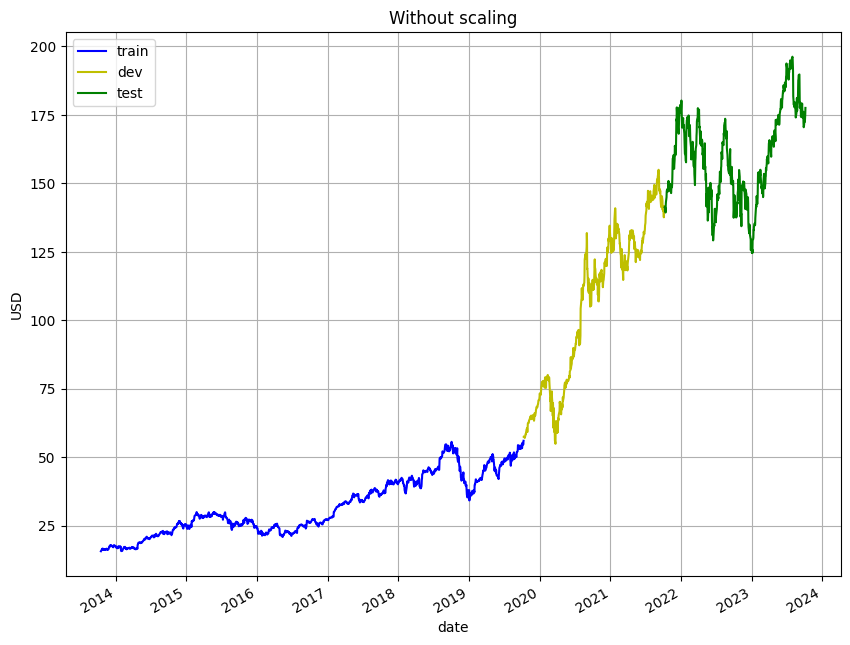

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

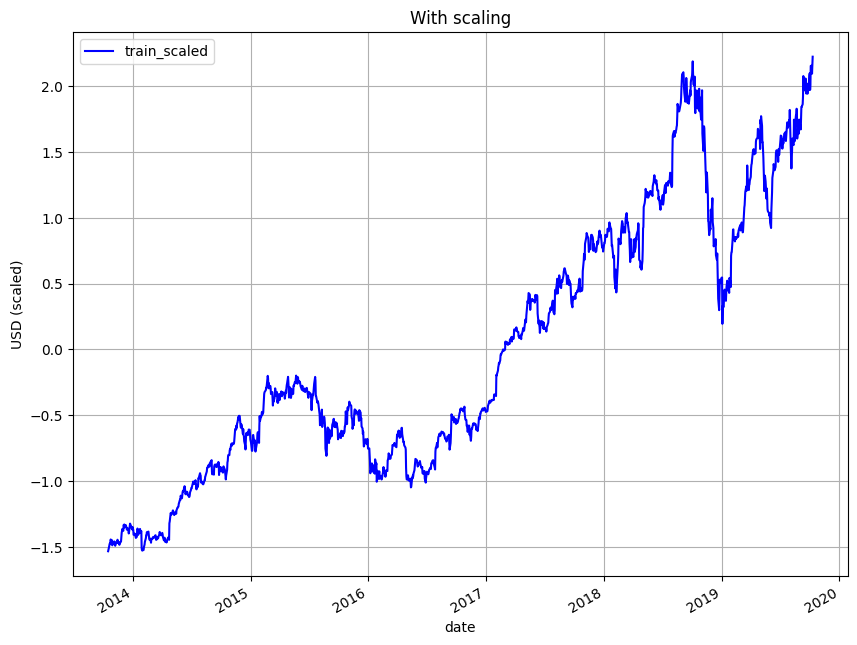

In [28]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [29]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [30]:
# Do prediction on train set

est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.416
MAPE on train set = 0.926%


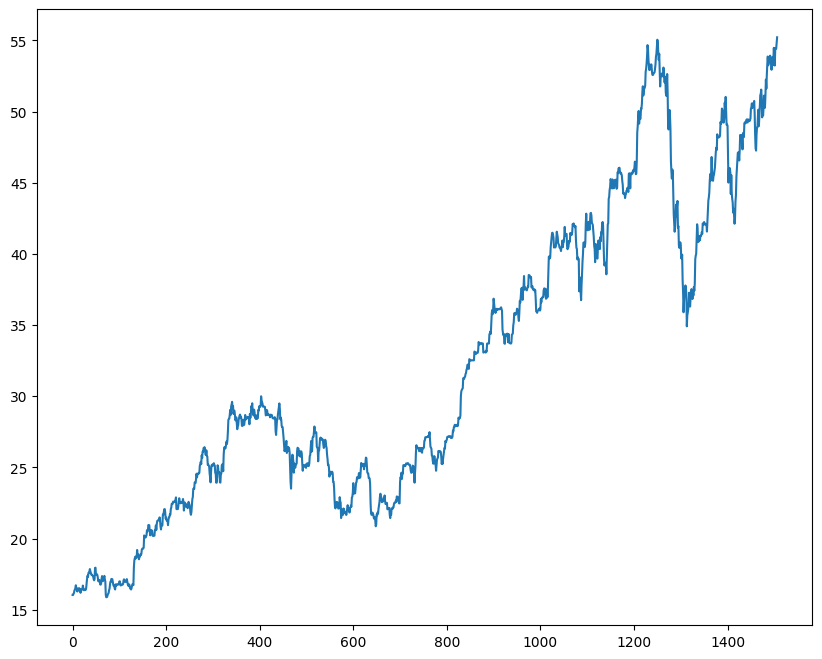

In [31]:
plt.plot(est)

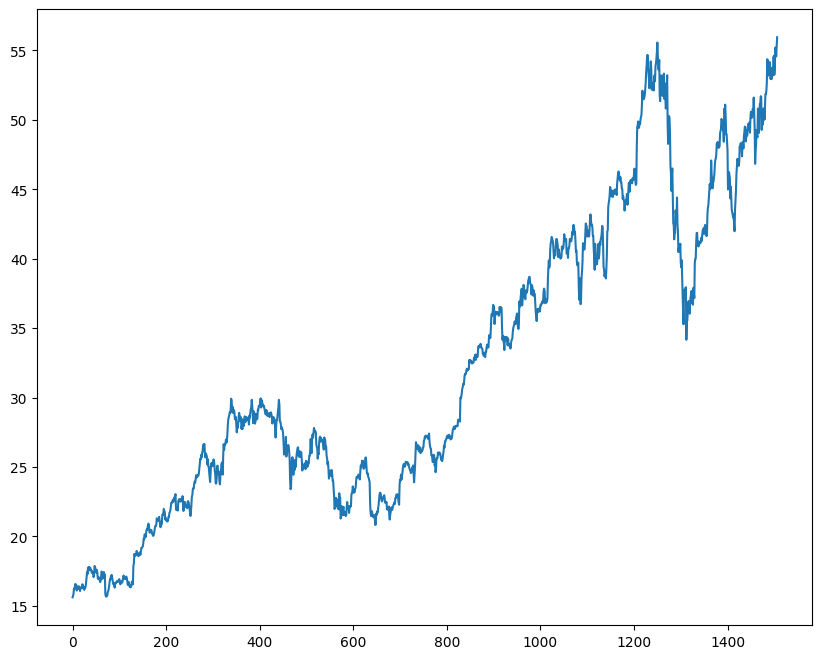

In [32]:
plt.plot(y_train)

Text(0.5, 1.0, 'Without scaling')

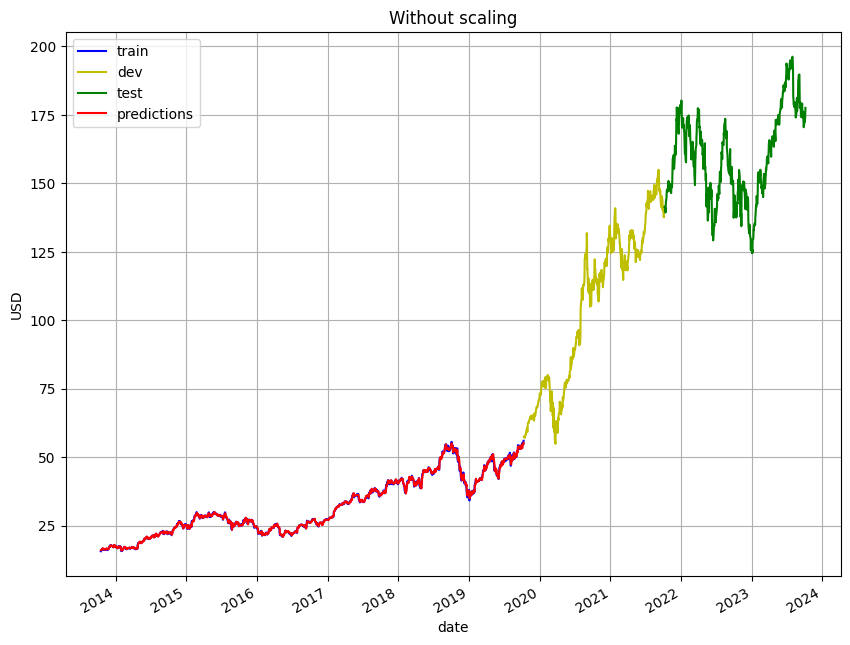

In [33]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [34]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 2.239
MAPE on dev set = 1.594%


<ipython-input-34-2191fa052402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
<ipython-input-34-2191fa052402>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'USD')

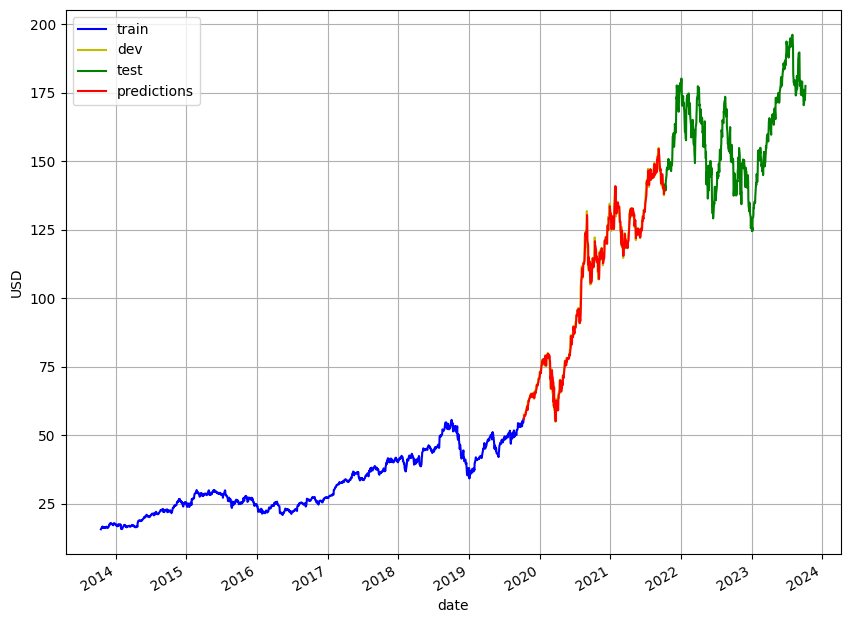

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'],
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [36]:
est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)

<Axes: xlabel='date', ylabel='USD'>

Text(0.5, 1.0, 'Zoom in to dev set')

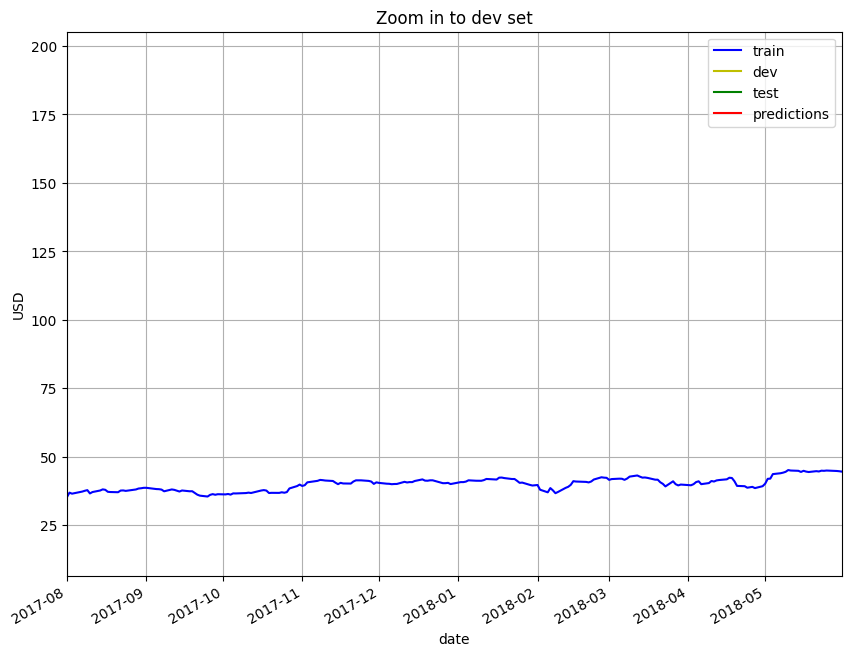

In [37]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

In [38]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1])
imp[-10:]



[('range_oc_lag_2', 0.00025290568),
 ('volume_lag_2', 0.00027611115),
 ('range_hl_lag_2', 0.00028964895),
 ('range_oc_lag_1', 0.00030220638),
 ('range_hl_lag_3', 0.00030890564),
 ('volume_lag_1', 0.00031983032),
 ('volume_lag_3', 0.00034498613),
 ('adj_close_lag_3', 0.011765651),
 ('adj_close_lag_2', 0.43481076),
 ('adj_close_lag_1', 0.5508642)]

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [39]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic =time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param,
                                     max_depth=param2,
                                     learning_rate=learning_rate,
                                     min_child_weight=min_child_weight,
                                     subsample=subsample,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-39-3f0f6eeb9608>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/30 [00:00<?, ?it/s]

,n_estimators,max_depth,rmse,mape_pct
0,10,2,2.294954,1.627823
1,10,3,2.272924,1.615149
2,10,4,2.293496,1.628469
3,10,5,2.271356,1.613487
4,10,6,2.329939,1.652598
...,...,...,...,...
235,300,5,2.234333,1.592359
236,300,6,2.282096,1.623107
237,300,7,2.279931,1.622770
238,300,8,2.283298,1.622188


In [40]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 2.232
optimum params = 


(200, 2)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [41]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=param,
                                     min_child_weight=param2,
                                     subsample=subsample,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-41-9881f9b3fb82>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/7 [00:00<?, ?it/s]

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,2.516510,1.808814
1,0.001,6,2.516510,1.808814
2,0.001,7,2.516510,1.808814
3,0.001,8,2.516510,1.808814
4,0.001,9,2.516510,1.808814
...,...,...,...,...
107,0.300,16,2.231738,1.589458
108,0.300,17,2.232060,1.590582
109,0.300,18,2.230904,1.590199
110,0.300,19,2.232336,1.591425


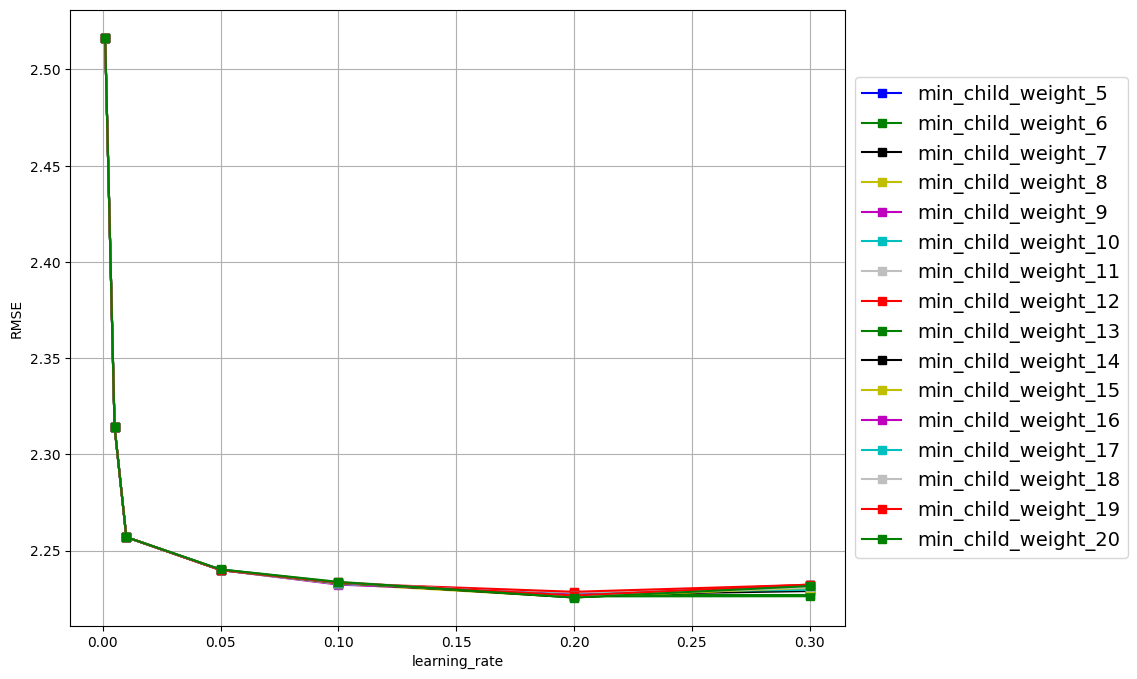

In [42]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [43]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 2.226
optimum params = 


(0.2, 20)

In [44]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.588%
optimum params = 


(0.3, 13)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [45]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=learning_rate_opt,
                                     min_child_weight=min_child_weight_opt,
                                     subsample=param,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-45-44e9e2bf93ca>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,2.307964,1.648721
1,0.1,0.2,2.319116,1.658481
2,0.1,0.3,2.320777,1.660117
3,0.1,0.4,2.324701,1.660985
4,0.1,0.5,2.301482,1.644409
...,...,...,...,...
95,1.0,0.6,2.229148,1.589690
96,1.0,0.7,2.229047,1.589534
97,1.0,0.8,2.229155,1.589792
98,1.0,0.9,2.228805,1.589058


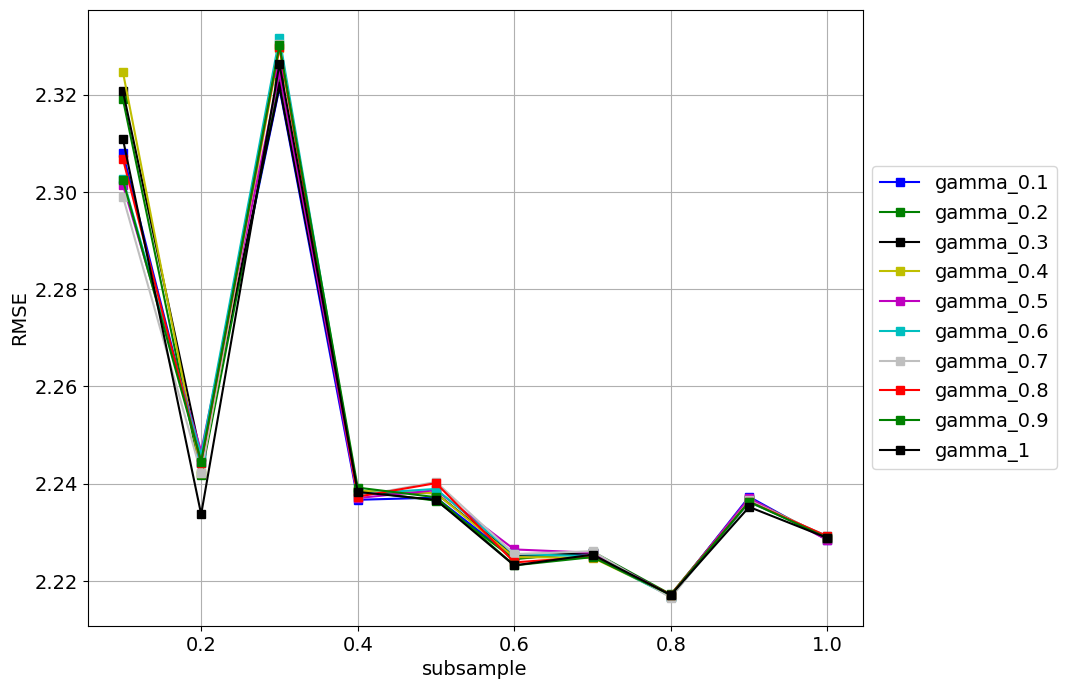

In [46]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [47]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 2.217
optimum params = 


(0.8, 0.7)

In [48]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.581%
optimum params = 


(0.8, 0.7)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [49]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=learning_rate_opt,
                                     min_child_weight=min_child_weight_opt,
                                     subsample=subsample_opt,
                                     colsample_bytree=param,
                                     colsample_bylevel=param2,
                                     gamma=gamma_opt)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-49-4e671f9552b9>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/6 [00:00<?, ?it/s]

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,2.470532,1.768803
1,0.5,0.6,2.470532,1.768803
2,0.5,0.7,2.543013,1.824454
3,0.5,0.8,2.543013,1.824454
4,0.5,0.9,2.460752,1.768443
5,0.5,1.0,2.412605,1.727160
6,0.6,0.5,2.692820,1.937037
7,0.6,0.6,2.493385,1.771485
8,0.6,0.7,2.493385,1.771485
9,0.6,0.8,2.504017,1.789741


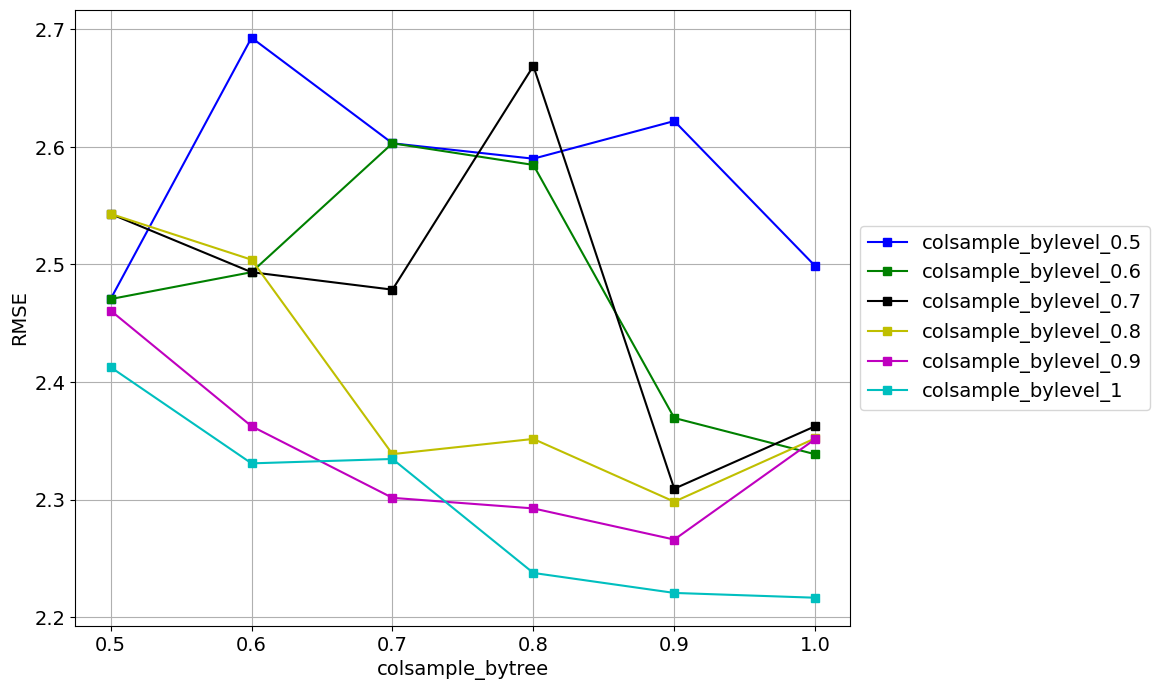

In [50]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [51]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 2.217
optimum params = 


(1.0, 1.0)

In [52]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.580%
optimum params = 


(0.9, 1.0)

# Tuned params

In [53]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,200.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.200
3,min_child_weight,1.000,20.000
4,subsample,1.000,0.800
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.700
8,rmse,2.239,2.217
9,mape_pct,1.594,1.580


# FINAL MODEL.

In [54]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled,
                             y_train_cv_scaled,
                             X_sample_scaled,
                             y_sample,
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt,
                             max_depth=max_depth_opt,
                             learning_rate=learning_rate_opt,
                             min_child_weight=min_child_weight_opt,
                             subsample=subsample_opt,
                             colsample_bytree=colsample_bytree_opt,
                             colsample_bylevel=colsample_bylevel_opt,
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 3.207
MAPE on test set = 1.600%


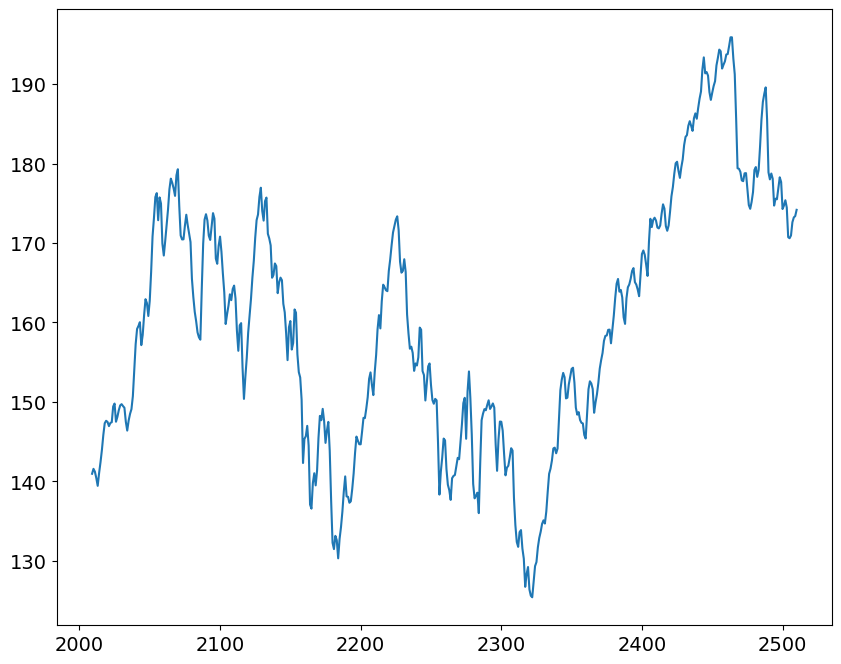

In [55]:
plt.plot(est)

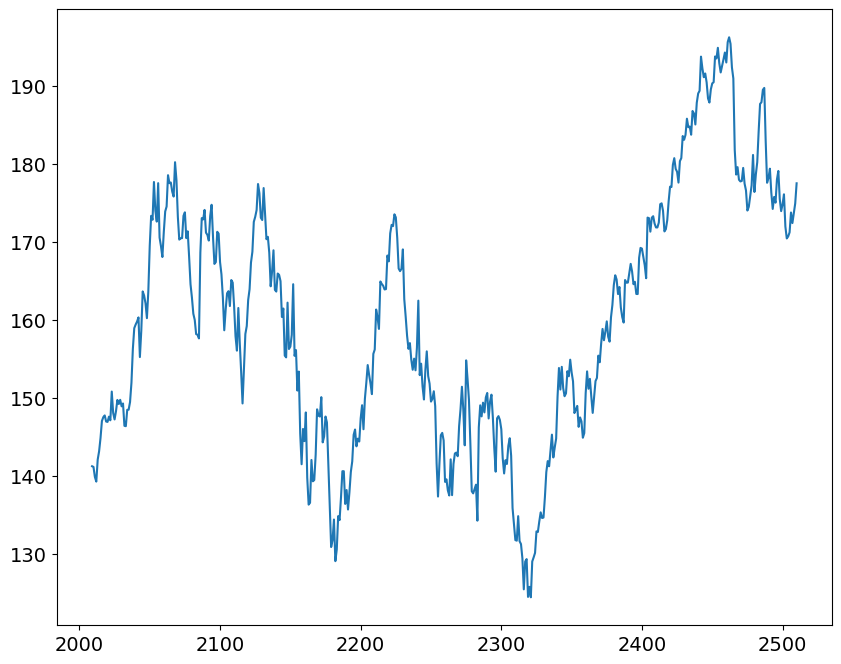

In [56]:
plt.plot( y_sample)

Text(0, 0.5, 'USD')

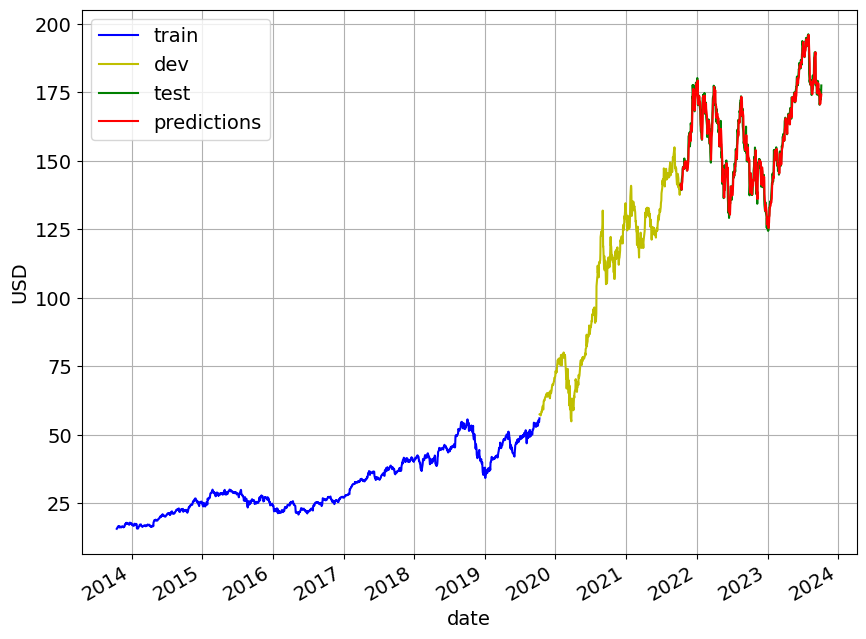

In [57]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")